In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")



In [2]:
df = pd.read_csv('flights.csv', low_memory=False)


In [3]:
print ('Dataframe dimensions:', df.shape)

Dataframe dimensions: (5819079, 31)


In [4]:
df['date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

In [5]:
remove_column = ['TAIL_NUMBER', 'DIVERTED', 'CANCELLATION_REASON', 'CANCELLED', 'DAY', 'MONTH', 'YEAR', 'LATE_AIRCRAFT_DELAY', 'TAXI_OUT', 'TAXI_IN', 'WHEELS_OFF', 'WHEELS_ON', 'AIR_SYSTEM_DELAY', 'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'WEATHER_DELAY']
df.drop(remove_column, axis = 1, inplace = True)
df.columns


Index(['DAY_OF_WEEK', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME',
       'DISTANCE', 'ARRIVAL_DELAY', 'date'],
      dtype='object')

#### 

In [6]:
df = df[['DAY_OF_WEEK', 'date', 'AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE']]
df.tail(10)

,DAY_OF_WEEK,date,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE
5819069,4,2015-12-31,B6,LAS,JFK,159.0,159.0,282.0,282.0,243.0,2248
5819070,4,2015-12-31,B6,RNO,JFK,0.0,-21.0,306.0,285.0,268.0,2411
5819071,4,2015-12-31,B6,SLC,MCO,16.0,17.0,249.0,250.0,211.0,1931
5819072,4,2015-12-31,B6,DEN,JFK,7.0,-11.0,211.0,193.0,173.0,1626
5819073,4,2015-12-31,B6,ABQ,JFK,16.0,3.0,227.0,214.0,190.0,1826
5819074,4,2015-12-31,B6,LAX,BOS,-4.0,-26.0,320.0,298.0,272.0,2611
5819075,4,2015-12-31,B6,JFK,PSE,-4.0,-16.0,227.0,215.0,195.0,1617
5819076,4,2015-12-31,B6,JFK,SJU,-9.0,-8.0,221.0,222.0,197.0,1598
5819077,4,2015-12-31,B6,MCO,SJU,-6.0,-10.0,161.0,157.0,144.0,1189
5819078,4,2015-12-31,B6,JFK,BQN,15.0,2.0,221.0,208.0,189.0,1576


In [7]:
#df['under 10 minutes delay'] = np.where(df['ARRIVAL_DELAY'] <= 10, 'yes', 'no')
#df.tail(10)
under_15 = df[(df['ARRIVAL_DELAY'] >1) & (df['ARRIVAL_DELAY'] <=15)]
over_15 = df[(df['ARRIVAL_DELAY'] >15) & (df['ARRIVAL_DELAY'] <=30)]
over_30 = df[(df['ARRIVAL_DELAY'] >30) & (df['ARRIVAL_DELAY'] <=50)]
over_50 = df[(df['ARRIVAL_DELAY'] >50) & (df['ARRIVAL_DELAY'] <=1440)]
over_1day = df[(df['ARRIVAL_DELAY'] >1440)]



In [8]:
a = under_15['ARRIVAL_DELAY'].count()
b = over_15['ARRIVAL_DELAY'].count()
c = over_30['ARRIVAL_DELAY'].count()
d = over_50['ARRIVAL_DELAY'].count()
e = over_1day['ARRIVAL_DELAY'].count()


In [9]:
df_new = pd.DataFrame({'-15': [a], '+15': [b], '+30': [c], '+50': [d], '+1day': [e]})
df_new


,+15,+1day,+30,+50,-15
0,390801,32,240931,391734,949144


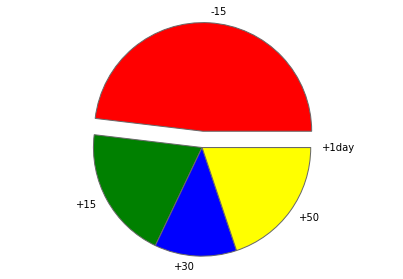

In [10]:
import numpy as np
import matplotlib.pyplot as plt

N = 5
data = [949144, 390801, 240931, 391734, 32]
# to ensure axes are square
plt.axes([0, 0, 0.9, 0.9])
# or axes(aspect=1)

# explode specifies the fraction of the radius with which to offset each wedge
plt.pie(data, explode = (0.15, 0, 0, 0, 0), labels = ("-15", "+15", "+30", "+50", "+1day"), colors = ["red", "green", "blue", "yellow", "purple"])
plt.axis('equal')

plt.show()


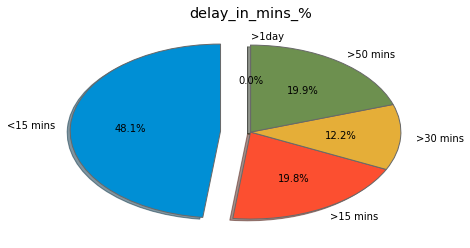

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

data = {'<15 mins': [949144],'>15 mins': [390801],'>30 mins': [240931],'>50 mins': [391734],'>1day': [32]}
labels= data.keys()
sizes=data.values()
explode = (0.2, 0, 0, 0,0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.title.set_text('delay_in_mins_%')